## Import Libraries

In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
from quspin.tools.evolution import expm_multiply_parallel
from quspin.operators import quantum_LinearOperator
from quspin.operators import quantum_operator
plt.rcParams['figure.figsize'] = [10, 8]

## Define Constants/Helpers

In [2]:
N = 8
N_filled = N // 2
E_neg1 = 0
P_neg1 = np.exp(-1j * E_neg1)
t = -0.5
g = 0#1e-3
m = -0.8
PBC = True

In [3]:
def stringbox(lst, caption):
    return caption + "-" * (100 - len(caption))+"\n" + str(lst) + "\n" + "-" * 100

## Spin Basis Simulation

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [0.5, 3, 4], [0.5, 4, 5], [0.5, 5, 6], [0.5, 6, 7], [-0.5, 7, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [0.5, 4, 3], [0.5, 5, 4], [0.5, 6, 5], [0.5, 7, 6], [-0.5, 0, 7]]], ['+-', [[-0.8, 0, 0], [0.8, 1, 1], [-0.8, 2, 2], [0.8, 3, 3], [-0.8, 4, 4], [0.8, 5, 5], [-0.8, 6, 6], [0.8, 7, 7]]], ['+-', [[0, 0, 0]]], ['+-+-', [[0, 0, 0, 0, 0]]], ['+-', [[0, 0, 0], [0, 1, 1]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1]]], ['+-', [[0, 0, 0], [0, 1, 1], [0, 2, 2]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 2], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1], [0, 1, 1, 2, 2], [0, 2, 2, 0, 0], [0, 2, 2, 1, 1], [0, 2, 2, 2, 2]]], ['+-', [[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 2], [0, 0, 0, 3, 3], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1], [0, 1, 1, 2, 2

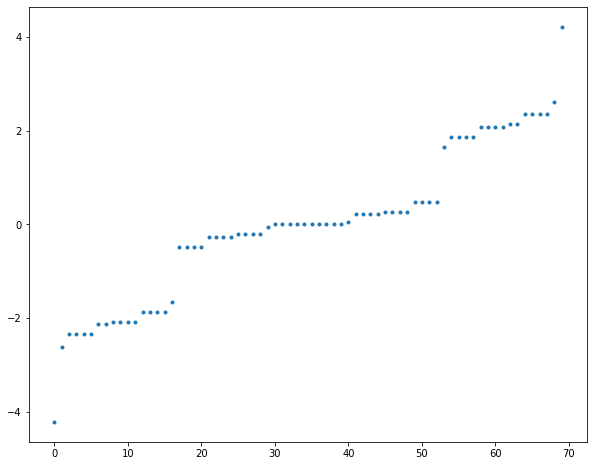

In [4]:
spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
if PBC and N_filled % 2 == 0:
    hop_coupling[-1][0] = -hop_coupling[-1][0]
    hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
def E_squared(n):
    E_const = E_neg1 + (n + 1) // 2
    s_coupling = []
    d_coupling = []
    for i in range(n + 1):
        s_coeff = 2 * E_const * -g
        s_coupling += [[s_coeff, i, i]]
        for j in range(n + 1):
            d_coeff = -g
            d_coupling += [[d_coeff, i, i, j, j]]
    return [["+-", s_coupling], ["+-+-", d_coupling]]
for i in range(N):
    static_terms += E_squared(i)

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)
spin_eigvals = H.eigvalsh()
plt.plot(spin_eigvals, ".")
plt.show()

In [5]:
# This is used later in real time dynamics, so keep a copy
H_init = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


## Fermion Basis

Static couplings:-----------------------------------------------------------------------------------
[['+-', [[0.5, 0, 1], [0.5, 1, 2], [0.5, 2, 3], [0.5, 3, 4], [0.5, 4, 5], [0.5, 5, 6], [0.5, 6, 7], [0.5, 7, 0]]], ['+-', [[0.5, 1, 0], [0.5, 2, 1], [0.5, 3, 2], [0.5, 4, 3], [0.5, 5, 4], [0.5, 6, 5], [0.5, 7, 6], [0.5, 0, 7]]], ['+-', [[-0.8, 0, 0], [0.8, 1, 1], [-0.8, 2, 2], [0.8, 3, 3], [-0.8, 4, 4], [0.8, 5, 5], [-0.8, 6, 6], [0.8, 7, 7]]], ['+-', [[0, 0, 0]]], ['+-+-', [[0, 0, 0, 0, 0]]], ['+-', [[0, 0, 0], [0, 1, 1]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1]]], ['+-', [[0, 0, 0], [0, 1, 1], [0, 2, 2]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 2], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1], [0, 1, 1, 2, 2], [0, 2, 2, 0, 0], [0, 2, 2, 1, 1], [0, 2, 2, 2, 2]]], ['+-', [[0, 0, 0], [0, 1, 1], [0, 2, 2], [0, 3, 3]]], ['+-+-', [[0, 0, 0, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 2, 2], [0, 0, 0, 3, 3], [0, 1, 1, 0, 0], [0, 1, 1, 1, 1], [0, 1, 1, 2, 2],

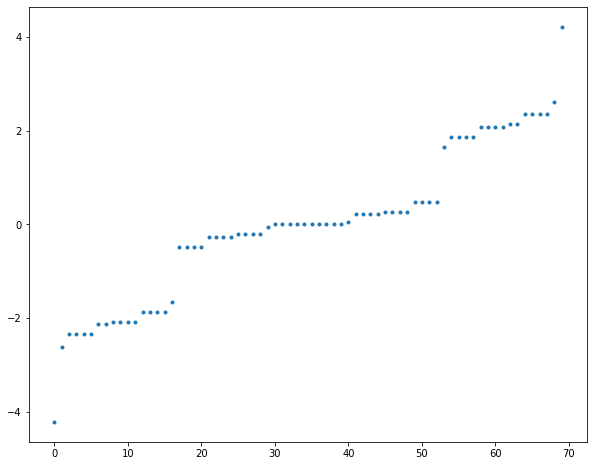

In [6]:
fermion_basis = spinless_fermion_basis_1d(L=N, Nf=N_filled)
fermion_basis_m1 = spinless_fermion_basis_1d(L=N, Nf=N_filled-1)
basis_full = spinless_fermion_basis_1d(L=N)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
# E_link_parity = lambda x : -1 if (x % 4) < 2 else 1
# for i in range(N):
#     E_coupling = [P_neg1 * -g * E_link_parity(i) * 2 ** (i+1)] + list(range(i+1))
#     static_terms += [["z" * (i+1), [E_coupling]]]
def E_squared(n):
    E_const = E_neg1 + (n + 1) // 2
    s_coupling = []
    d_coupling = []
    for i in range(n + 1):
        s_coeff = 2 * E_const * -g
        s_coupling += [[s_coeff, i, i]]
        for j in range(n + 1):
            d_coeff = -g
            d_coupling += [[d_coeff, i, i, j, j]]
    return [["+-", s_coupling], ["+-+-", d_coupling]]
for i in range(N):
    static_terms += E_squared(i)

print(stringbox(static_terms, "Static couplings:"))
### Plotting spectrum
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)
fermion_eigvals = H.eigvalsh()
plt.plot(fermion_eigvals, ".")
plt.show()

## Comparison

In [7]:
mdiff = max(abs(fermion_eigvals - spin_eigvals))
print(stringbox(fermion_eigvals, "Fermion eigenvalues:"))
print(stringbox(spin_eigvals, "Spin eigenvalues:"))
print("Maximum difference between eigenvalues:", mdiff)

Fermion eigenvalues:--------------------------------------------------------------------------------
[-4.21604050e+00 -2.61604050e+00 -2.34833267e+00 -2.34833267e+00
 -2.34833267e+00 -2.34833267e+00 -2.13541565e+00 -2.13541565e+00
 -2.08062485e+00 -2.08062485e+00 -2.08062485e+00 -2.08062485e+00
 -1.86770783e+00 -1.86770783e+00 -1.86770783e+00 -1.86770783e+00
 -1.65479080e+00 -4.80624847e-01 -4.80624847e-01 -4.80624847e-01
 -4.80624847e-01 -2.67707825e-01 -2.67707825e-01 -2.67707825e-01
 -2.67707825e-01 -2.12917022e-01 -2.12917022e-01 -2.12917022e-01
 -2.12917022e-01 -5.47908029e-02 -2.43381018e-16 -2.31391428e-16
 -1.00810986e-16 -4.44558129e-17  3.64915752e-17  1.02236031e-16
  1.81816574e-16  3.42555985e-16  3.96332316e-16  5.77352825e-16
  5.47908029e-02  2.12917022e-01  2.12917022e-01  2.12917022e-01
  2.12917022e-01  2.67707825e-01  2.67707825e-01  2.67707825e-01
  2.67707825e-01  4.80624847e-01  4.80624847e-01  4.80624847e-01
  4.80624847e-01  1.65479080e+00  1.86770783e+00  1.86

## Real-time Dynamics

In [8]:
### Defining time-evolution hamiltonian
spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
static_terms = []
dynamic_terms = []

### Hopping term
L = (N if PBC else N-1)
hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
if PBC and N_filled % 2 == 0:
    hop_coupling[-1][0] = -hop_coupling[-1][0]
    hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
static_terms += [["+-", hop_coupling]]
static_terms += [["+-", hop_coupling_dag]]

### Mass term
mass_coupling = [[-m * (-1) ** i, i, i] for i in range(N)]
static_terms += [["+-", mass_coupling]]

### E-field term
for i in range(N):
    static_terms += E_squared(i)

H = hamiltonian(static_terms, dynamic_terms, basis=spin_basis, dtype=np.complex64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [9]:
E_init,V_init=H_init.eigsh(k=1,which='SA',maxiter=1e8)
psi_i = V_init[:,0]
psi_i = psi_i.reshape((-1,))
del H_init

In [10]:
T = 3#g ** (-1)
dt = T / 30

##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
# construct piece-wise constant unitaries
expH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
# auxiliary array for memory efficiency
psi=psi_i.copy().astype(np.complex128)
work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
# prepare output
loschmidt = []
for i in range(len(times)):
    if i % (len(times)//10) == 0:
        print("# T = ",times[i])
    Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
    print(f"{times[i]}\t {Lt[i]}")
    loschmidt += [Lt[i]]
    expH.dot(psi,work_array=work_array,overwrite_v=True)
# END of time evolution

# T =  0.0
0.0	 3.638018717039017e-09
0.1	 0.002383964006417483
0.2	 0.009594674548571127
# T =  0.30000000000000004
0.30000000000000004	 0.021814212190616335
0.4	 0.03936567801754283
0.5	 0.06274639930689616
# T =  0.6000000000000001
0.6000000000000001	 0.09268252438856261
0.7000000000000001	 0.13021365055550607
0.8	 0.1768132575594992
# T =  0.9
0.9	 0.23451026543213985
1.0	 0.3057243490991716
1.1	 0.3912345816355568
# T =  1.2000000000000002
1.2000000000000002	 0.48187535641468965
1.3	 0.5600779549812046
1.4000000000000001	 0.6318798547662747
# T =  1.5
1.5	 0.6312485362416821
1.6	 0.510874564386141
1.7000000000000002	 0.3920025135050668
# T =  1.8
1.8	 0.2999778213191532
1.9000000000000001	 0.22879915767457198
2.0	 0.17278366586359056
# T =  2.1
2.1	 0.1282615034317604
2.2	 0.09288923449979117
2.3000000000000003	 0.0651325232621441
# T =  2.4000000000000004
2.4000000000000004	 0.04396766001498967
2.5	 0.028712134224645667
2.6	 0.018927467160196866
# T =  2.7
2.7	 0.0143643474775404

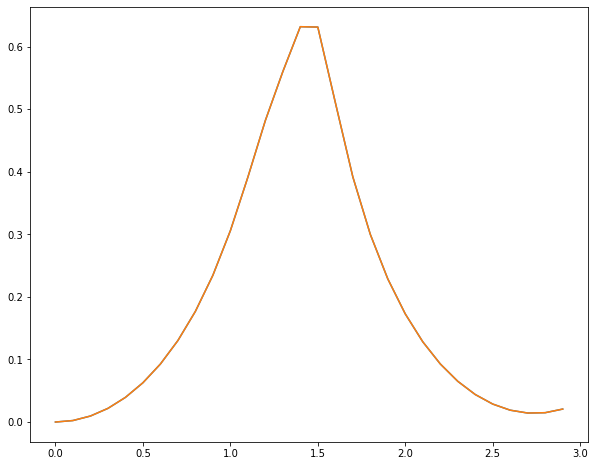

In [11]:
plt.plot(times, loschmidt)
other_lo = np.array([5.551115123125783935e-17,
2.383960624939180772e-03,
9.594671966069567154e-03,
2.181421104303998826e-02,
3.936567911556990845e-02,
6.274640374652884489e-02,
9.268253369496309846e-02,
1.302136668009789278e-01,
1.768132830506458364e-01,
2.345102997029978042e-01,
3.057243705082459684e-01,
3.912344459831388344e-01,
4.818744580195983840e-01,
5.600755226031685075e-01,
6.318780378552437682e-01,
6.312543411204991628e-01,
5.108766920734136852e-01,
3.920030579428742112e-01,
2.999780090385165132e-01,
2.287992403759356308e-01,
1.727837081739250213e-01,
1.282615266840427259e-01,
9.288924730312264622e-02,
6.513252968768533380e-02,
4.396766225437569869e-02,
2.871213359977805094e-02,
1.892746456180881276e-02,
1.436434358204656189e-02,
1.493487410384876195e-02,
2.070482216075825513e-02
])
plt.plot(times, other_lo)
plt.show()

## Correlator calculation

In [12]:
def c_operator(n):
    cdag_static = [["-",[[1.0,n]]]]
    cdagn = quantum_LinearOperator(cdag_static,basis=basis_full,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
    return(cdagn)
annihilators = [c_operator(n) for n in range(N)]

In [13]:
##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
H = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis, dtype=np.float64)

# array to store correlators expectations from psi(t,n) to psi(0,0)
correlators = np.zeros((N,len(times)),dtype=np.complex128)

P_Nhalf = fermion_basis.get_proj(dtype=np.float64)
P_Nhalfminus1 = fermion_basis_m1.get_proj(dtype=np.float64)

for n in range(0, N, 2): #loop over all site pairings
    for i in range(len(times)): #loop over times (for annhilator location)
        # Even Correlators
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

        expmiH = expm_multiply_parallel((np.transpose(P_Nhalfminus1).dot(P_Nhalf.dot(H.tocsr().dot(np.transpose(P_Nhalf)))).dot(P_Nhalfminus1)),a=-1j*dt*i,dtype=dtype_cmplx)
        expiH = expm_multiply_parallel(H.tocsr(),a=1j*dt*i,dtype=dtype_cmplx)

        expiH.dot(leftPsi,overwrite_v=True) 
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[0].dot(P_Nhalf.dot(rightPsi)))

        correlators[n,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
        
        # Odd Correlators
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

        expiH.dot(leftPsi,overwrite_v=True) 
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n+1].dot(P_Nhalf.dot(leftPsi)))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[1].dot(P_Nhalf.dot(rightPsi)))

        correlators[n+1,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
    
# correlators = correlators#/(len(times)/dt) # Averaging over N so that it is actually an expectation value
# END of time evolution

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [14]:
print(correlators[:,0])

[ 0.89040391+0.00000000e+00j  0.10959596+0.00000000e+00j
 -0.04691313-1.70445096e-09j  0.04691309+1.10064014e-08j
  0.01576973+2.82453079e-08j -0.01576969-8.58794935e-08j
 -0.04691316+6.91822941e-08j  0.04691319-3.87849843e-08j]


In [15]:
correlatorfft = []
for i in range(len(correlators[0, :])):
    fftsum = np.fft.fft(correlators[::2,i]) + np.fft.fft(correlators[1::2,i])
    correlatorfft.append(fftsum)
    
correlatorfft = np.array(correlatorfft)

# Fix the correlatorFFT to be symmetric
mode_count = correlatorfft.shape[1]
BZ_edge = mode_count // 2 + 1
wrap_order = (np.arange(mode_count) + BZ_edge) % mode_count
print(wrap_order)
correlatorfft = correlatorfft[:, wrap_order]

[3 0 1 2]


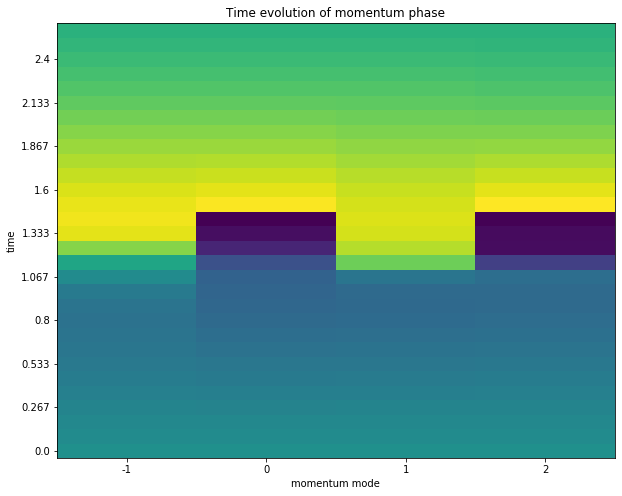

In [16]:
# plt.plot(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)))
plt.xlabel("momentum mode")
plt.ylabel("time")
plt.title("Time evolution of momentum phase")
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,N//2,step_x) # pixel count at label position
x_labels = np.arange(N//4-N//2+1, N//4+1) # labels you want to see
plt.xticks(x_positions, x_labels)
y_tickcount = 10 # How many labels on y axis
y_positions = np.arange(0,int(T/dt), int((T/dt)/y_tickcount)) # pixel count at label position
y_labels = np.round(np.linspace(0,abs(T*m),y_tickcount), 3) # labels you want to see
plt.yticks(y_positions, y_labels)
plt.imshow(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)), aspect='auto', origin='lower')

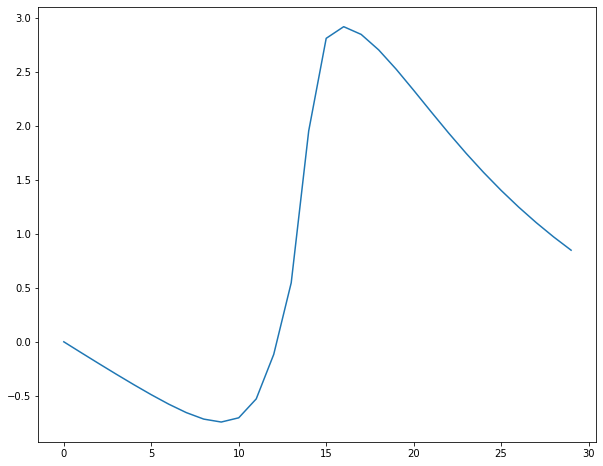

In [17]:
phases = np.arctan2(np.imag(correlatorfft), np.real(correlatorfft))
plt.plot(phases[:,0])
plt.show()

Text(0.5, 0, 'Time Slice')

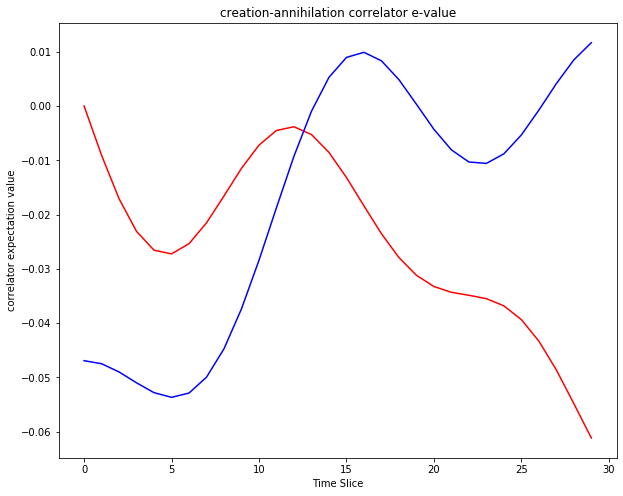

In [18]:
plt.plot(np.imag(correlators[2, :]),color='red',label="Imaginary Part")
plt.plot(np.real(correlators[2, :]),color='blue',label="Real Part")
plt.title("creation-annihilation correlator e-value")
plt.ylabel("correlator expectation value")
plt.xlabel("Time Slice")
# plt.figlegend()

## Niklas Code

Symmetry checks passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Symmetry checks passed!
N8_Gt_n0_done
Symmetry checks passed!
N8_Gt_n1_done
Symmetry checks passed!
N8_Gt_n2_done
Symmetry checks passed!
N8_Gt_n3_done
Symmetry checks passed!
N8_Gt_n4_done
Symmetry checks passed!
N8_Gt_n5_done
Symmetry checks passed!
N8_Gt_n6_done
Symmetry checks passed!
N8_Gt_n7_done
[ 0.89040391+0.00000000e+00j  0.10959596+0.00000000e+00j
 -0.04691313-1.70445096e-09j  0.04691309+1.10064014e-08j
  0.01576973+2.82453079e-08j -0.01576969-8.58794935e-08j
 -0.04691316+6.91822941e-08j  0.04691319-3.87849843e-08j]


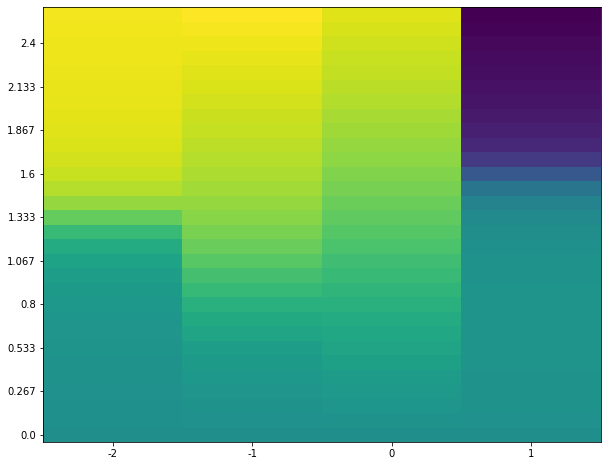

[ 0.00000000e+00 -1.10435926e-18 -3.31307779e-18 -5.52179632e-18
 -1.43566704e-17  3.31307779e-18  3.31307779e-18 -5.52179632e-18
 -5.52179632e-18 -3.64438557e-17 -7.73051485e-18 -4.30700113e-17
 -4.74874484e-17 -4.30700113e-17 -3.42351372e-17 -2.54002631e-17
 -1.65653890e-17 -2.98177001e-17 -3.20264187e-17 -3.20264187e-17
 -2.31915446e-17 -3.20264187e-17 -3.64438557e-17 -1.87741075e-17
 -3.64438557e-17 -4.08612928e-17 -4.74874484e-17 -4.36221909e-17]
[ 0.00000000e+00  0.00000000e+00 -3.31307779e-18 -5.52179632e-19
 -7.73051485e-18 -1.51849399e-17 -8.55878430e-18  1.18718621e-17
  3.03698798e-18  8.28269448e-19  5.24570651e-18 -1.24240417e-17
 -1.24240417e-17 -3.00937900e-17  5.24570651e-18 -6.54332864e-17
 -6.54332864e-17  5.24570651e-18  5.24570651e-18 -1.36112279e-16
 -6.54332864e-17 -3.00937900e-17 -3.00937900e-17 -3.00937900e-17
 -4.77635382e-17 -1.24240417e-17  5.24570651e-18  1.40805806e-17]


In [19]:
psi_init = psi_i.copy().astype(np.complex128)

# apply c_0 & c_1 to initial state
c0_static = [["-",[[1.0,0]]]]
c0 = quantum_LinearOperator(c0_static,basis=basis_full,dtype=np.float64,check_herm=False,check_pcon=False)
psi_init_c0 = np.transpose(P_Nhalfminus1).dot(c0.dot(P_Nhalf.dot(psi_init)))
# del c0
c1_static = [["-",[[1.0,1]]]]
c1 = quantum_LinearOperator(c1_static,basis=basis_full,dtype=np.float64,check_herm=False,check_pcon=False)
psi_init_c1 = np.transpose(P_Nhalfminus1).dot(c1.dot(P_Nhalf.dot(psi_init)))
# del c1
H_quenched = hamiltonian(static_terms, dynamic_terms, basis=fermion_basis_m1, dtype=np.float64)
# evolving in time (forward)
psi_t_c0 = H_quenched.evolve(psi_init_c0,0,times)#,solver_name='dopri5',atol=1e-16,rtol=1e-16)
psi_t_c1 = H_quenched.evolve(psi_init_c1,0,times)#,solver_name='dopri5',atol=1e-16,rtol=1e-16)
# del H_quenched
#print(np.shape(psi_t))
H_quenched_r =  -hamiltonian(static_terms,dynamic_terms,basis=fermion_basis,dtype=np.float64)
Gnt_all = []
for n in range(N):
    Gnt = np.zeros(len(times),dtype=np.complex128)
    # apply c_n^\dagger to evolved states
    psi_t_cn = []
    cn_static = [["+",[[1.0,n]]]]
    cn = quantum_LinearOperator(cn_static,basis=basis_full,dtype=np.float64,check_herm=False,check_pcon=False)
    for t in range(len(times)):
        if n%2 == 0:
            psi_t_cn.append( np.transpose(P_Nhalf).dot(cn.dot(P_Nhalfminus1.dot(psi_t_c0[:,t]))) )
        if n%2 == 1:
            psi_t_cn.append( np.transpose(P_Nhalf).dot(cn.dot(P_Nhalfminus1.dot(psi_t_c1[:,t]))) )
    del cn
    psi_t_cn = np.array(psi_t_cn)
    #print(np.shape(psi_t_cn))
    # evolve backwards in time & get the correlators
    for t in range(len(times)):
        psi_t_cn[t,:] = H_quenched_r.evolve(psi_t_cn[t,:],0,times[t])
        Gnt[t] = np.vdot(psi_init,psi_t_cn[t,:])
    print('N'+str(N)+'_Gt_n'+str(n)+'_done')
    Gnt_all.append(Gnt)
Gnt_all = np.array(Gnt_all)
print(Gnt_all[:,0])
#np.save(folder_save+'/TwoTime_correlators',Gnt_all)
Nt = len(times)
Gnt_half = np.zeros((N//2,Nt),dtype=np.complex128)
for n in range(N//2):
    Gnt_half[n,:] = Gnt_all[2*n,:] + Gnt_all[2*n+1,:]
Gkt = np.fft.fft(Gnt_half,axis=0)

# Fix the correlatorFFT to be symmetric
diff = correlatorfft - Gkt.T
correlatorfft = Gkt.T
# mode_count = correlatorfft.shape[1]
# BZ_edge = mode_count // 2 + 1
# wrap_order = (np.arange(mode_count) + BZ_edge) % mode_count
# print(wrap_order)
# correlatorfft = correlatorfft[:, wrap_order]
# plt.xlabel("momentum mode")
# plt.ylabel("time")
# plt.title("Time evolution of momentum phase")

#Plot FFT
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,N//2,step_x) # pixel count at label position
x_labels = np.arange(N//4-N//2, N//4) # labels you want to see
plt.xticks(x_positions, x_labels)
y_tickcount = 10 # How many labels on y axis
y_positions = np.arange(0,int(T/dt), int((T/dt)/y_tickcount)) # pixel count at label position
y_labels = np.round(np.linspace(0,abs(T*m),y_tickcount), 3) # labels you want to see
plt.yticks(y_positions, y_labels)
plt.imshow(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)), aspect='auto', origin='lower')
plt.show()

Lt_from_Gkt = -np.sum(np.log(np.abs(Gkt)),axis=0)/N
# np.savetxt(folder_save+'/rate_TwoTime',np.array(Lt_from_Gkt)/a)
Nk, Nt = np.shape(Gkt)
dphi_kt_k = np.zeros((Nk,Nt-1))
dphi_kt_t = np.zeros((Nk,Nt-1))
Fkt = np.zeros((Nk,Nt-2))
for k in range(Nk):
    for t in range(Nt-1):
        dphi_kt_k[k,t] = np.angle(Gkt[(k+1)%Nk,t]/Gkt[k,t])
        dphi_kt_t[k,t] = np.angle(Gkt[k,t+1]/Gkt[k,t])
for k in range(Nk):
    for t in range(Nt-2):
        Fkt[k,t] = (dphi_kt_k[k,t] + dphi_kt_t[(k+1)%Nk,t]) - (dphi_kt_k[k,t+1] + dphi_kt_t[k,t])
Fkt_ksum1 = np.zeros(Nt-2)
Fkt_ksum2 = np.zeros(Nt-2)
for k in range(Nk//2):
    Fkt_ksum1 += Fkt[(k),:]/2/np.pi
    Fkt_ksum2 += Fkt[(k+Nk//2),:]/2/np.pi
n1 = []
n2 = []
for t in range(Nt-2):
    ntau1 = 0
    ntau2 = 0
    for tau in range(0,t):
        ntau1 += Fkt_ksum1[tau]
        ntau2 += Fkt_ksum2[tau]
    n1.append(ntau1)
    n2.append(ntau2)
n1 = np.array(n1)
n2 = np.array(n2)
print(n1)
print(n2)

In [20]:
print(H_quenched)

static mat: 
  (0, 0)	0.8
  (0, 1)	0.5
  (0, 25)	-0.5
  (1, 0)	0.5
  (1, 1)	-0.8
  (1, 2)	0.5
  (1, 6)	0.5
  (1, 29)	-0.5
  (2, 1)	0.5
  (2, 2)	0.8
  (2, 3)	0.5
  (2, 7)	0.5
  (2, 32)	-0.5
  (3, 2)	0.5
  (3, 3)	-0.8
  (3, 4)	0.5
  (3, 8)	0.5
  (3, 34)	-0.5
  (4, 3)	0.5
  (4, 4)	0.8
  (4, 5)	0.5
  (4, 9)	0.5
  (4, 35)	-0.5
  (5, 4)	0.5
  (5, 5)	-0.8
  :	:
  (50, 49)	0.5
  (50, 50)	-2.4000000000000004
  (50, 51)	0.5
  (50, 53)	0.5
  (51, 13)	-0.5
  (51, 45)	0.5
  (51, 50)	0.5
  (51, 51)	-0.8
  (51, 54)	0.5
  (52, 49)	0.5
  (52, 52)	0.8
  (52, 53)	0.5
  (53, 15)	-0.5
  (53, 50)	0.5
  (53, 52)	0.5
  (53, 53)	-0.8
  (53, 54)	0.5
  (54, 16)	-0.5
  (54, 51)	0.5
  (54, 53)	0.5
  (54, 54)	0.8
  (54, 55)	0.5
  (55, 18)	-0.5
  (55, 54)	0.5
  (55, 55)	-0.8


dynamic:



1.7396553684177716
1.2913064318258585


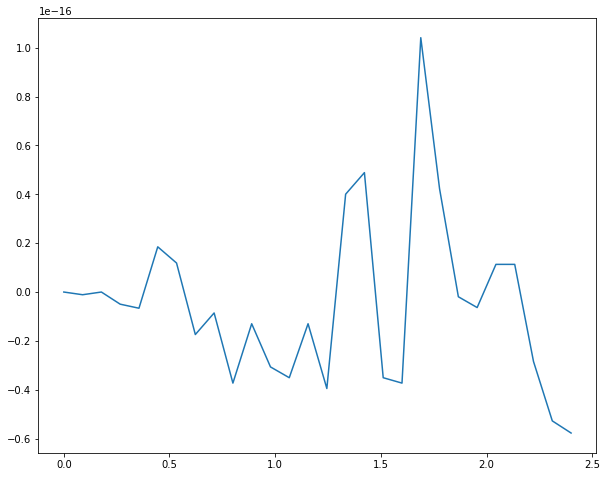

In [21]:
print(np.max(np.abs(diff)))
diff_corr = np.array(Gnt_all) - correlators
print(np.max(np.abs(diff_corr)))
plt.plot(np.linspace(0, T * -m, len(n1)), (n1-n2))
plt.show()
# plt.plot(np.linspace(0, T * -m, len(n1)), (n2))
# plt.show()